<title>IBM Data Science Professional Certificate<title/>
 
This notebook is used for IBM's Applied Data Science Course's capstone project. 

# IBM Data Science Professional Certificate
## Capstone Project - Battle of Neighbourhoods
### Introduction - Business Problem
The main purpose of this project is finding the best neighbourhood in London, by considering the rental prices, crime numbers and venues. The safest borough with a reasonable average rent will be found. Then neighbourhoods of found borough will be analysed according to the most common venue categories.
### Data
•	List of London Boroughs with their designations: https://en.wikipedia.org/wiki/London_boroughs

•	Number of Crimes by London Boroughs: https://drive.google.com/file/d/1TTOhuQit4gkenrUizsUn9wloHalRffhE/view

•	London Rental Prices by Boroughs: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/adhocs/11100privaterentalmarketinlondonjanuary2019todecember2019

•	Foursquare API

### Methodology
#### Exploratory Analysis
Statistical basics will be used. Collected data will be sorted, filtered and compared to produce an outcome which will be an input for the next step.
#### Modelling 
Kmean clustering method will be used to cluster neigbourhoods according to their venues types. Similar neighbourhoods will be in the same cluster to enable person to make a decision. 

In [681]:
#Necessary Libraries and Packages 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as soup
from urllib.request import Request,urlopen

import geocoder
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import folium

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors



Solving environment: \ 
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_2
  - defaults/osx-64::openssl-1.1.1d-h1de35ccdone

# All requested packages already installed.



In [682]:
CLIENT_ID = '3LBBKMPI2EYBRBFMBBODMS3402O2ODMVGRSXY0CGWT3P2MIM' # your Foursquare ID
CLIENT_SECRET = '2LRKRPSZLXEB31FBQQIXDUTZ3NEJ2YL15IO1325V3FT534T4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
radius = 500
LIMIT = 30

Your credentails:
CLIENT_ID: 3LBBKMPI2EYBRBFMBBODMS3402O2ODMVGRSXY0CGWT3P2MIM
CLIENT_SECRET:2LRKRPSZLXEB31FBQQIXDUTZ3NEJ2YL15IO1325V3FT534T4


### Data
#### Collection, Handling, Cleaning

In [210]:
df_crime = pd.read_csv('Downloads/London_crime.csv') #create a dataframe from csv file of London Crime data 

In [211]:
df_crime.head() #Check out the dataframe

,MajorText,MinorText,LookUp_BoroughName,201803,201804,201805,201806,201807,201808,201809,...,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002
0,Arson and Criminal Damage,Arson,Barking and Dagenham,6,3,4,12,6,5,3,...,11,3,5,3,6,9,8,6,4,4
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,115,122,126,123,127,101,107,...,138,113,134,118,109,109,99,121,99,98
2,Burglary,Burglary - Business and Community,Barking and Dagenham,38,36,24,33,30,18,33,...,22,27,31,35,37,30,30,25,31,17
3,Burglary,Burglary - Residential,Barking and Dagenham,122,75,93,77,94,84,99,...,114,96,71,67,80,97,114,130,116,121
4,Drug Offences,Drug Trafficking,Barking and Dagenham,7,3,8,6,9,7,10,...,8,6,8,6,6,9,10,2,12,3


In [213]:
cols = df_crime.columns[3:] #extracting columns with the data of crimes monthly 
df_crime['2018-2020']= df_crime[cols].sum(axis=1) #calculating the sum of number of crimes for each type of crime
df_crime=df_crime.drop(df_crime.columns[3:-1],axis=1)#removing seperate monthly crime data
df_crime.head(10)

,MajorText,MinorText,LookUp_BoroughName,2018-2020
0,Arson and Criminal Damage,Arson,Barking and Dagenham,129
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,2775
2,Burglary,Burglary - Business and Community,Barking and Dagenham,726
3,Burglary,Burglary - Residential,Barking and Dagenham,2430
4,Drug Offences,Drug Trafficking,Barking and Dagenham,155
5,Drug Offences,Possession of Drugs,Barking and Dagenham,1987
6,Miscellaneous Crimes Against Society,Bail Offences,Barking and Dagenham,1
7,Miscellaneous Crimes Against Society,Bigamy,Barking and Dagenham,2
8,Miscellaneous Crimes Against Society,Dangerous Driving,Barking and Dagenham,26
9,Miscellaneous Crimes Against Society,"Disclosure, Obstruction, False or Misleading S...",Barking and Dagenham,1


In [214]:
df_crime=df_crime.rename(columns={'LookUp_BoroughName':'Borough'}) #renaming columns 
df_crime=df_crime[['Borough','2018-2020']]
df_crime.head(10)

,Borough,2018-2020
0,Barking and Dagenham,129
1,Barking and Dagenham,2775
2,Barking and Dagenham,726
3,Barking and Dagenham,2430
4,Barking and Dagenham,155
5,Barking and Dagenham,1987
6,Barking and Dagenham,1
7,Barking and Dagenham,2
8,Barking and Dagenham,26
9,Barking and Dagenham,1


In [215]:
df_crime=df_crime.groupby('Borough',as_index=False)[['2018-2020']].sum() 
# calculating total number of crimes for each borough regardless of crime type
df_crime.head(10)

,Borough,2018-2020
0,Barking and Dagenham,38796
1,Barnet,60534
2,Bexley,34099
3,Brent,61154
4,Bromley,48810
5,Camden,76081
6,Croydon,65738
7,Ealing,60811
8,Enfield,59263
9,Greenwich,55330


In [222]:
df_crime=df_crime.sort_values(by='2018-2020').reset_index(drop=True)
#Sorting data in a ascending order accordign to crime numbers
df_crime

,Borough,2018-2020
0,London Heathrow and London City Airports,6997
1,Richmond upon Thames,25819
2,Kingston upon Thames,25858
3,Sutton,26575
4,Merton,28432
5,Harrow,32880
6,Bexley,34099
7,Havering,38149
8,Barking and Dagenham,38796
9,Hammersmith and Fulham,46188


<b>It should be noted that City of London is not included in the dataframe, it is not a borough of London. Following data will be checked and if it is not necessary, crime numbers for City of London area will be skipped for this analysis. </b>

In [327]:
df_rent = pd.read_excel('Downloads/londonrentalstatisticsq42019.xls',sheet_name='Table 1.2',header=11,usecols="B:H",nrows=198)
#Creating a dataframe from an excel file which has rental price data
df_rent=df_rent.drop(columns=df_rent.columns[4:]) #ignoring unnecessary columns of the table  
df_rent.head(10)

,Borough,Bedroom Category,Count of rents,Mean
0,Barking and Dagenham,Room,20,482
1,Barking and Dagenham,Studio,20,742
2,Barking and Dagenham,One Bedroom,220,984
3,Barking and Dagenham,Two Bedrooms,380,1190
4,Barking and Dagenham,Three Bedrooms,260,1428
5,Barking and Dagenham,Four or More Bedrooms,40,1653
6,Barnet,Room,20,544
7,Barnet,Studio,110,864
8,Barnet,One Bedroom,400,1149
9,Barnet,Two Bedrooms,770,1388


<b>Rows with index number 36,40,41,156 had non integer values. So They needed to be removed to calculate average rent by borough<b/>

In [328]:
df_rent.drop(index=[36,40,41,156],inplace=True) #handling non-integer values 
# Calculating Average rental price for each borough. sum(meanXcounts)/total_counts
df_rent['Tot_Mean'] = df_rent['Mean'] * df_rent['Count of rents'] 
df_rent=df_rent.drop(['Bedroom Category','Mean'],axis=1)
df_rent=df_rent.groupby(['Borough'],as_index=False).sum()
df_rent['Avg_rent'] = df_rent['Tot_Mean'] / df_rent['Count of rents']
df_rent=df_rent.drop(['Count of rents','Tot_Mean'],axis=1)

In [330]:
df_rent=df_rent.sort_values(by='Avg_rent').reset_index(drop=True) # sorting in ascending order according to rental price
df_rent

,Borough,Avg_rent
0,Bexley,1119.492958
1,Croydon,1126.730924
2,Sutton,1158.394231
3,Havering,1159.202020
4,Barking and Dagenham,1202.723404
5,Hillingdon,1218.068966
6,Lewisham,1299.909091
7,Waltham Forest,1310.406780
8,Enfield,1313.475610
9,Redbridge,1319.348571


In [334]:
df_crime=df_crime.rename(columns={'2018-2020':'Number_of_Crime'})

In [355]:
# a method to handle beautiful soup
def scrapper(wiki_url,table_name):
    wiki_data = urlopen(wiki_url)   
    wiki_html = wiki_data.read()
    wiki_data.close()
    
    page_src = soup(wiki_html,'html.parser') #html source of the page getting scrapped.
    tbl = page_src.findAll('table',{'class': table_name}) #finding the needed table. 
    tbl = tbl[0]
    return tbl


In [356]:
scrap_url = 'https://en.wikipedia.org/wiki/London_boroughs' # scrapping wikipedia for list of London Boroughs 
wiki_table_1 = scrapper(scrap_url,'wikitable sortable')

In [361]:
headers_table1 = wiki_table_1.find_all('th',{})

In [363]:
headers_table1 = headers_table1[:2]

In [364]:
headers_table1

[<th>London borough
 </th>, <th>Designation
 </th>]

In [367]:
col_names_table1 = ['Borough','Designation']


In [390]:
# handling scrapped html in order to obtain meaningful table
den = wiki_table_1.find_all('tr',{})[1:]
dem=den[1].find_all('td',{})
first_cols_data = []
rows_data_1 = []
rows_data_2 = []
for k in dem[:2:2]:
    fcd = k.get_text()
    rows_data_1.append(fcd)
    print('first row first col: ',fcd)
for k in dem[1:2:2]:
    scd = k.get_text()
    rows_data_2.append(scd)
    print('second row second col: ',scd)

first row first col:  Greenwich

second row second col:  Inner



In [395]:
den[1].find_all('td')[1].get_text()

'Inner\n'

In [433]:
rows_data_col1= []
rows_data_col2= []
for d in den[0:]:
    dem = d.find_all('td',{})
    fcd = dem[0].get_text()
    scd = dem[1].get_text()
    rows_data_col1.append(fcd[:-1])
    rows_data_col2.append(scd[:-1])
print(rows_data_col1)
print(rows_data_col2)

['Camden', 'Greenwich', 'Hackney', 'Hammersmith[notes 2]', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster', 'Barking[notes 3]', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Croydon', 'Ealing', 'Enfield', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Kingston upon Thames', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Sutton', 'Waltham Forest']
['Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Inner', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer', 'Outer']


In [437]:
df_Borough_designation = pd.DataFrame(list(zip(rows_data_col1,rows_data_col2)),columns=col_names_table1)

In [438]:
df_Borough_designation # dataframe shows London Boroughs and their Inner/Outer designations

,Borough,Designation
0,Camden,Inner
1,Greenwich,Inner
2,Hackney,Inner
3,Hammersmith[notes 2],Inner
4,Islington,Inner
5,Kensington and Chelsea,Inner
6,Lambeth,Inner
7,Lewisham,Inner
8,Southwark,Inner
9,Tower Hamlets,Inner


In [439]:
df_Borough_designation.loc[3]['Borough'] = 'Hammersmith and Fulham' #removing unnecessary characters from scrapped data 
df_Borough_designation.loc[12]['Borough']= 'Barking and Dagenham'
df_Borough_designation

,Borough,Designation
0,Camden,Inner
1,Greenwich,Inner
2,Hackney,Inner
3,Hammersmith and Fulham,Inner
4,Islington,Inner
5,Kensington and Chelsea,Inner
6,Lambeth,Inner
7,Lewisham,Inner
8,Southwark,Inner
9,Tower Hamlets,Inner


In [424]:
set(df_crime['Borough']) - set(df_Borough_designation['Borough']) # check if tables have same number of boroughs 

{'Barking and Dagenham',
 'Camden',
 'Hammersmith and Fulham',
 'London Heathrow and London City Airports'}

In [425]:
set(df_Borough_designation['Borough']) - set(df_crime['Borough'])

{'Barking', 'Hammersmith'}

In [429]:
set(df_crime['Borough']) - set(df_rent['Borough'])

set()

In [427]:
set(df_rent['Borough']) - set(df_crime['Borough'])

{'City of London'}

In [414]:
set(df_crime['Borough'])-set(df['Borough'])

{'Barking and Dagenham',
 'Camden',
 'Hammersmith and Fulham',
 'London Heathrow and London City Airports'}

In [428]:
df_crime = df_crime[df_crime['Borough'] != 'London Heathrow and London City Airports']
#in order to get rid of an area in crime dataframe, which cannot be rented by anyone

In [463]:
set(df_crime['Borough']) - set(df_Borough_designation['Borough'])

{'City of London'}

<b>Borough designation dataframe does not have City of London either, because City of London is not classified as a London borough. However, it might be useful to have for our analysis<b/>

In [465]:
df_Borough_designation=df_Borough_designation.append({'Borough':'City of London','Designation':'Inner'},ignore_index=True)

In [448]:
print('Mean of the number of crime Boroughs: ',df_crime['Number_of_Crime'].mean())
print('Median of the number of crime Boroughs: ',df_crime['Number_of_Crime'].median())

Mean of the number of crime Boroughs:  55305.03125
Median of the number of crime Boroughs:  53998.5


In [450]:
df_crime['Number_of_Crime'].describe()

count        32.000000
mean      55305.031250
std       22770.626845
min       25819.000000
25%       44340.000000
50%       53998.500000
75%       64017.500000
max      149734.000000
Name: Number_of_Crime, dtype: float64

<b>Since we do not have a relevant crime data for City of London, the value around median value is used as a crime number of the area<b/>

In [456]:
df_crime=df_crime.append({'Borough': 'City of London','Number_of_Crime':55305},ignore_index=True)

In [459]:
df_crime=df_crime.sort_values(by='Number_of_Crime').reset_index(drop=True)

In [675]:
#Merging all the dataframes which are created seperately into a single dataframe
df = pd.merge(df_rent,df_Borough_designation,on='Borough')
df = pd.merge(df,df_crime,on='Borough')
df.head()

,Borough,Avg_rent,Designation,Number_of_Crime
0,Bexley,1119.492958,Outer,34099
1,Croydon,1126.730924,Outer,65738
2,Sutton,1158.394231,Outer,26575
3,Havering,1159.202020,Outer,38149
4,Barking and Dagenham,1202.723404,Outer,38796


<b>As a young white collar employee, I would like to live as close to the centre of London as possible. This is why outer boroughs of London are ignored.<b/>

In [676]:
df=df[df['Designation']=='Inner'].reset_index(drop=True) #Extracting inner London Boroughs
df

,Borough,Avg_rent,Designation,Number_of_Crime
0,Lewisham,1299.909091,Inner,55707
1,Greenwich,1480.238636,Inner,55330
2,Southwark,1712.898477,Inner,76149
3,Lambeth,1726.454545,Inner,71240
4,Hackney,1769.586207,Inner,66324
5,Tower Hamlets,1777.375000,Inner,69452
6,Wandsworth,1898.714829,Inner,52270
7,Islington,1917.857143,Inner,59540
8,Hammersmith and Fulham,2010.779070,Inner,46188
9,Camden,2171.184615,Inner,76081


### Analysis
#### Exploratory Analysis

In [677]:
df=df.sort_values(by='Number_of_Crime').reset_index(drop=True) #Safety is first priority
df=df.drop(columns=['Designation']) # Not necessary any longer.
df

,Borough,Avg_rent,Number_of_Crime
0,Hammersmith and Fulham,2010.779070,46188
1,Kensington and Chelsea,2964.680180,47517
2,Wandsworth,1898.714829,52270
3,City of London,2198.600000,55305
4,Greenwich,1480.238636,55330
5,Lewisham,1299.909091,55707
6,Islington,1917.857143,59540
7,Hackney,1769.586207,66324
8,Tower Hamlets,1777.375000,69452
9,Lambeth,1726.454545,71240


In [637]:
df_PP1 = df[['Borough','Number_of_Crime']]


In [638]:
df_PP1.set_index('Borough',inplace=True)

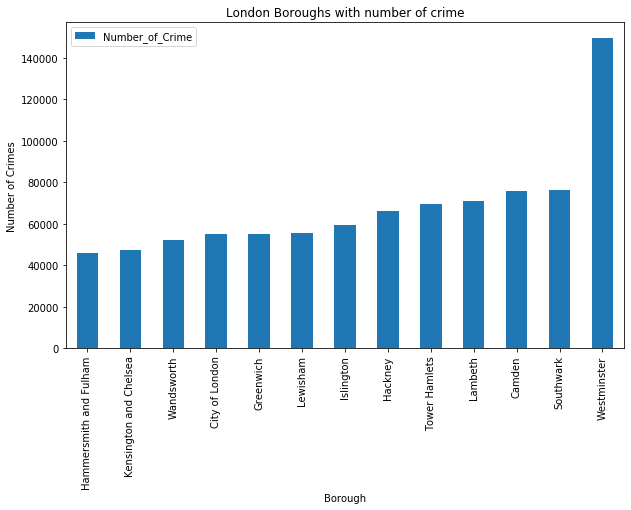

In [641]:
#Plotting Crime numbers
pp = df_PP1.plot(kind='bar', figsize=(10, 6), rot=0)

pp.set_ylabel('Number of Crimes') # add to x-label to the plot
pp.set_xlabel('Borough') # add y-label to the plot
pp.set_title('London Boroughs with number of crime') # add title to the plot

plt.xticks(rotation=90)
plt.show()

<b>The most dangerous 25% should be excluded immediately.<b/>

In [678]:
df=df.head(9) # Removing most dangerous 25% of the Boroughs
df

,Borough,Avg_rent,Number_of_Crime
0,Hammersmith and Fulham,2010.779070,46188
1,Kensington and Chelsea,2964.680180,47517
2,Wandsworth,1898.714829,52270
3,City of London,2198.600000,55305
4,Greenwich,1480.238636,55330
5,Lewisham,1299.909091,55707
6,Islington,1917.857143,59540
7,Hackney,1769.586207,66324
8,Tower Hamlets,1777.375000,69452


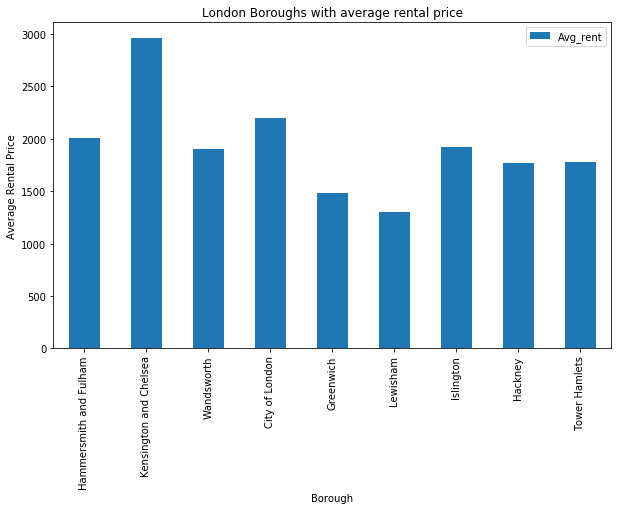

In [644]:
#Plotting Rental Prices
df_PP2 = df[['Borough','Avg_rent']]
df_PP2.set_index('Borough',inplace=True)

pp = df_PP2.plot(kind='bar', figsize=(10, 6), rot=0)

pp.set_ylabel('Average Rental Price') # add to x-label to the plot
pp.set_xlabel('Borough') # add y-label to the plot
pp.set_title('London Boroughs with average rental price') # add title to the plot

plt.xticks(rotation=90)
plt.show()


In [645]:
df['Avg_rent'].describe()

count       9.000000
mean     1924.193351
std       474.128656
min      1299.909091
25%      1769.586207
50%      1898.714829
75%      2010.779070
max      2964.680180
Name: Avg_rent, dtype: float64

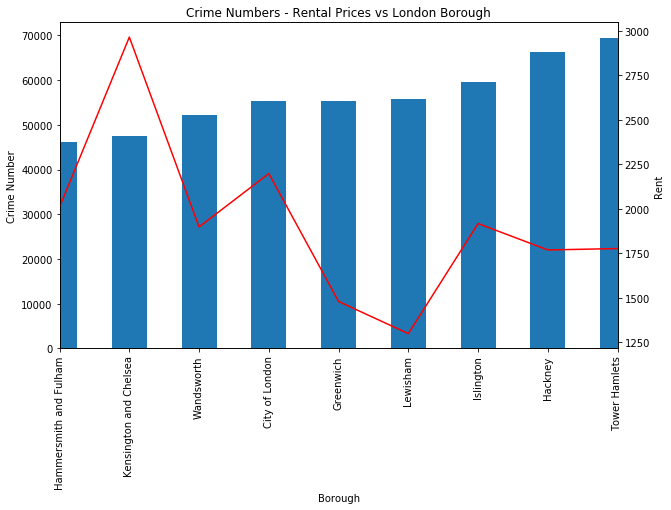

In [679]:
# Plotting crime numbers & rental prices together to see from a wider perspective.
ax1=df['Number_of_Crime'].plot(kind='bar', figsize=(10, 6))
ax2=df['Avg_rent'].plot(secondary_y=True,color='r')

ax1.set_xlabel('Borough')
ax1.set_ylabel('Crime Number')
ax1.set_title("Crime Numbers - Rental Prices vs London Borough")
ax2.set_ylabel('Rent')

aaa = df['Borough'].to_numpy()

ax1.set_xticklabels(aaa,rotation=90)

plt.show()

<b>As a personal intuition, I tend to select an average price, instead of cheapest. So anything out of the range 25%-75% is dropped<b/>

In [680]:
df = df[df['Avg_rent']<2010]
df= df[df['Avg_rent']>1760]
df

,Borough,Avg_rent,Number_of_Crime
2,Wandsworth,1898.714829,52270
6,Islington,1917.857143,59540
7,Hackney,1769.586207,66324
8,Tower Hamlets,1777.375000,69452


<b>Wandsworth would be the best choice<b/>

<b> List of Neighboorhood is found on wikipedia page with following link: https://en.wikipedia.org/wiki/London_Borough_of_Wandsworth#Localities. Creating a list manually is easier than scrapping the webpage in this case<b/>

In [507]:
neigh_Wandsworth = ['Balham','Battersea','Earlsfield','Furzedown','Nine Elms','Putney',
'Putney Heath','Putney Vale','Roehampton','Southfields',
'Streatham Park',
'Tooting',
'Tooting Bec/Upper Tooting',
'Wandsworth',
'West Hill']
#List of Neighbourhood in Wandsworth

In [510]:
Latitude = []
Longitude = []
#Location data for each neighbour in Wandsworth
for i in range(len(neigh_Wandsworth)):
    address = '{},London,United Kingdom'.format(neigh_Wandsworth[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.4456449, 51.4707933, 51.4464482, 51.424389, 51.4787433, 51.4625524, 51.44284195, 51.4380193, 51.4498773, 51.4457751, 51.4249386, 51.4266588, 51.4356086, 51.4570271, 51.4516571] [-0.1503643, -0.172214, -0.1893941, -0.1537022, -0.1362629, -0.2167462, -0.23220739691221765, -0.2459701, -0.2412672, -0.2066142, -0.1450602, -0.1690768, -0.1596548, -0.1932607, -0.2162189]


In [511]:
df_Neigh_Wandsworth = pd.DataFrame(list(zip(neigh_Wandsworth,Latitude,Longitude)),columns=['Neighbourhood','Latitude','Longitude'])
df_Neigh_Wandsworth #dataframe shows the list of neighbourhoods

,Neighbourhood,Latitude,Longitude
0,Balham,51.445645,-0.150364
1,Battersea,51.470793,-0.172214
2,Earlsfield,51.446448,-0.189394
3,Furzedown,51.424389,-0.153702
4,Nine Elms,51.478743,-0.136263
5,Putney,51.462552,-0.216746
6,Putney Heath,51.442842,-0.232207
7,Putney Vale,51.438019,-0.245970
8,Roehampton,51.449877,-0.241267
9,Southfields,51.445775,-0.206614


In [545]:
#drawing the map of neighbourhoods
map_london = folium.Map(location=[Latitude[0], Longitude[0]], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_Neigh_Wandsworth['Latitude'], df_Neigh_Wandsworth['Longitude'], df_Neigh_Wandsworth['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [547]:
#Method to obtain venue data around the neighbourhoods by usign Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [548]:
Wandsworth_venues = getNearbyVenues(names=df_Neigh_Wandsworth['Neighbourhood'],
                                   latitudes=df_Neigh_Wandsworth['Latitude'],
                                   longitudes=df_Neigh_Wandsworth['Longitude']
                                  )

Wandsworth_venues.head(10)

Balham
Battersea
Earlsfield
Furzedown
Nine Elms
Putney
Putney Heath
Putney Vale
Roehampton
Southfields
Streatham Park
Tooting
Tooting Bec/Upper Tooting
Wandsworth
West Hill


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balham,51.445645,-0.150364,We Brought Beer,51.444324,-0.150656,Beer Store
1,Balham,51.445645,-0.150364,M1LK,51.444450,-0.150913,Coffee Shop
2,Balham,51.445645,-0.150364,Ciullosteria,51.447144,-0.148981,Italian Restaurant
3,Balham,51.445645,-0.150364,Brickwood Coffee & Bread,51.444509,-0.151127,Coffee Shop
4,Balham,51.445645,-0.150364,Franco Manca,51.443616,-0.149959,Pizza Place
5,Balham,51.445645,-0.150364,Balham Bowls Club,51.444984,-0.152306,Pub
6,Balham,51.445645,-0.150364,Camden Coffee House,51.443271,-0.152967,Coffee Shop
7,Balham,51.445645,-0.150364,The Wine Tasting Shop,51.444461,-0.150912,Shop & Service
8,Balham,51.445645,-0.150364,Arlo's,51.444733,-0.151907,Steakhouse
9,Balham,51.445645,-0.150364,Brother Marcus,51.443668,-0.153339,Café


In [549]:
#Find unique categories
print('There are {} uniques categories.'.format(len(Wandsworth_venues['Venue Category'].unique())))

There are 86 uniques categories.


In [550]:
# one hot encoding
Wandsworth_onehot = pd.get_dummies(Wandsworth_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
Wandsworth_onehot['Neighbourhood'] = Wandsworth_venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [Wandsworth_onehot.columns[-1]] + list(Wandsworth_onehot.columns[:-1])
Wandsworth_onehot = Wandsworth_onehot[fixed_columns]

Wandsworth_onehot

,Neighbourhood,Asian Restaurant,Bakery,Bar,Baseball Field,Beer Store,Bike Shop,Bookstore,Brazilian Restaurant,Brewery,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Turkish Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,Balham,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,West Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,West Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,West Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,West Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [551]:
Wandsworth_onehot.shape

(269, 87)

In [552]:
Wandsworth_grouped = Wandsworth_onehot.groupby('Neighbourhood').mean().reset_index()
Wandsworth_grouped

,Neighbourhood,Asian Restaurant,Bakery,Bar,Baseball Field,Beer Store,Bike Shop,Bookstore,Brazilian Restaurant,Brewery,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Turkish Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,Balham,0.000000,0.066667,0.066667,0.00,0.033333,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
1,Battersea,0.033333,0.100000,0.033333,0.00,0.000000,0.000000,0.000000,0.000000,0.033333,...,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000
2,Earlsfield,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Furzedown,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Nine Elms,0.000000,0.000000,0.117647,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000
5,Putney,0.033333,0.033333,0.033333,0.00,0.033333,0.033333,0.033333,0.033333,0.000000,...,0.033333,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333
6,Putney Heath,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Putney Vale,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Roehampton,0.000000,0.090909,0.090909,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
9,Southfields,0.000000,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Modelling
#### Kmeans clustering 

In [553]:
#Print 10 most common venues for each neighbourhood.
num_top_venues = 10

for hood in Wandsworth_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Wandsworth_grouped[Wandsworth_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Balham----
                 venue  freq
0                  Pub  0.17
1          Coffee Shop  0.13
2                  Bar  0.07
3          Pizza Place  0.07
4               Bakery  0.07
5   Italian Restaurant  0.07
6          Yoga Studio  0.03
7           Steakhouse  0.03
8                  Gym  0.03
9  Moroccan Restaurant  0.03


----Battersea----
                          venue  freq
0                           Pub  0.13
1                        Bakery  0.10
2                         Hotel  0.07
3              Asian Restaurant  0.03
4                 Garden Center  0.03
5  General College & University  0.03
6                 Grocery Store  0.03
7               Harbor / Marina  0.03
8                      Heliport  0.03
9            Italian Restaurant  0.03


----Earlsfield----
                venue  freq
0                 Pub  0.12
1     Thai Restaurant  0.12
2       Grocery Store  0.12
3                Café  0.06
4              Lounge  0.06
5  Italian Restaurant  0.06
6    Indoor

In [536]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [554]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Wandsworth_grouped['Neighbourhood']

for ind in np.arange(Wandsworth_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Wandsworth_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,Pub,Coffee Shop,Italian Restaurant,Bakery,Bar,Pizza Place,Beer Store,Café,English Restaurant,Farmers Market
1,Battersea,Pub,Bakery,Hotel,Italian Restaurant,Grocery Store,Plaza,Pet Store,Japanese Restaurant,Heliport,Harbor / Marina
2,Earlsfield,Grocery Store,Thai Restaurant,Pub,Italian Restaurant,Café,Indoor Play Area,Gym,Lounge,Gastropub,Music Venue
3,Furzedown,Italian Restaurant,Convenience Store,Park,Chinese Restaurant,Café,Pizza Place,Gas Station,Fish & Chips Shop,Flea Market,Food Truck
4,Nine Elms,Grocery Store,Bar,Coffee Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place,Fish & Chips Shop,Restaurant,Café,Bus Stop


In [541]:
from sklearn.cluster import KMeans # necessary library for kmeans

In [555]:
# set number of clusters
kclusters = 5

Wandsworth_grouped_clustering = Wandsworth_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Wandsworth_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 1, 3, 3, 0], dtype=int32)

In [556]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Wandsworth_merged = df_Neigh_Wandsworth

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Wandsworth_merged = Wandsworth_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Wandsworth_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,51.445645,-0.150364,0,Pub,Coffee Shop,Italian Restaurant,Bakery,Bar,Pizza Place,Beer Store,Café,English Restaurant,Farmers Market
1,Battersea,51.470793,-0.172214,0,Pub,Bakery,Hotel,Italian Restaurant,Grocery Store,Plaza,Pet Store,Japanese Restaurant,Heliport,Harbor / Marina
2,Earlsfield,51.446448,-0.189394,0,Grocery Store,Thai Restaurant,Pub,Italian Restaurant,Café,Indoor Play Area,Gym,Lounge,Gastropub,Music Venue
3,Furzedown,51.424389,-0.153702,2,Italian Restaurant,Convenience Store,Park,Chinese Restaurant,Café,Pizza Place,Gas Station,Fish & Chips Shop,Flea Market,Food Truck
4,Nine Elms,51.478743,-0.136263,0,Grocery Store,Bar,Coffee Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place,Fish & Chips Shop,Restaurant,Café,Bus Stop


### Results 

In [581]:
# create map for clusters 
map_clusters = folium.Map(location=[Latitude[0], Longitude[0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Wandsworth_merged['Latitude'], Wandsworth_merged['Longitude'], Wandsworth_merged['Neighbourhood'], Wandsworth_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [570]:
#Neighbourhoods in the first cluster
Wandsworth_merged.loc[Wandsworth_merged['Cluster Labels'] == 0, Wandsworth_merged.columns[[0] + list(range(3, Wandsworth_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,0,Pub,Coffee Shop,Italian Restaurant,Bakery,Bar,Pizza Place,Beer Store,Café,English Restaurant,Farmers Market
1,Battersea,0,Pub,Bakery,Hotel,Italian Restaurant,Grocery Store,Plaza,Pet Store,Japanese Restaurant,Heliport,Harbor / Marina
2,Earlsfield,0,Grocery Store,Thai Restaurant,Pub,Italian Restaurant,Café,Indoor Play Area,Gym,Lounge,Gastropub,Music Venue
4,Nine Elms,0,Grocery Store,Bar,Coffee Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place,Fish & Chips Shop,Restaurant,Café,Bus Stop
5,Putney,0,Japanese Restaurant,Café,Burger Joint,Pub,Coffee Shop,Gastropub,Pizza Place,Pie Shop,Ice Cream Shop,Gym / Fitness Center
9,Southfields,0,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Bus Stop,Gym,Lebanese Restaurant,Flea Market,Park,Pharmacy
11,Tooting,0,Pub,Indian Restaurant,Bar,Market,Coffee Shop,Asian Restaurant,Café,Juice Bar,Lebanese Restaurant,Middle Eastern Restaurant
12,Tooting Bec/Upper Tooting,0,Coffee Shop,Indian Restaurant,Bakery,Pub,Italian Restaurant,Restaurant,Bar,Burger Joint,Convenience Store,Gas Station
13,Wandsworth,0,Pub,Asian Restaurant,Supermarket,Coffee Shop,Clothing Store,Restaurant,Portuguese Restaurant,Chocolate Shop,Gym / Fitness Center,Pharmacy


In [575]:
#Neighbourhoods in the second cluster
Wandsworth_merged.loc[Wandsworth_merged['Cluster Labels'] == 1, Wandsworth_merged.columns[[0] + list(range(3, Wandsworth_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Putney Heath,1,Park,Baseball Field,Yoga Studio,Gastropub,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Truck,Fried Chicken Joint,Garden Center


In [577]:
#Neighbourhoods in the third cluster
Wandsworth_merged.loc[Wandsworth_merged['Cluster Labels'] == 2, Wandsworth_merged.columns[[0] + list(range(3, Wandsworth_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Furzedown,2,Italian Restaurant,Convenience Store,Park,Chinese Restaurant,Café,Pizza Place,Gas Station,Fish & Chips Shop,Flea Market,Food Truck
10,Streatham Park,2,Convenience Store,Pub,Park,Grocery Store,Café,Yoga Studio,Gas Station,Fish & Chips Shop,Flea Market,Food Truck


In [578]:
#Neighbourhoods in the forth cluster
Wandsworth_merged.loc[Wandsworth_merged['Cluster Labels'] == 3, Wandsworth_merged.columns[[0] + list(range(3, Wandsworth_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Putney Vale,3,Bus Stop,Gas Station,Grocery Store,Supermarket,Outdoors & Recreation,Café,Yoga Studio,Fish & Chips Shop,Flea Market,Food Truck
8,Roehampton,3,Café,Bus Stop,Bakery,Bar,Wine Shop,Paper / Office Supplies Store,Supermarket,Pub,Grocery Store,Bus Station


In [579]:
#Neighbourhoods in the fifth cluster
Wandsworth_merged.loc[Wandsworth_merged['Cluster Labels'] == 4, Wandsworth_merged.columns[[0] + list(range(3, Wandsworth_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,West Hill,4,Gym,Park,Bus Stop,Wine Shop,Pub,Scenic Lookout,Bus Station,Music Venue,Gas Station,Fish & Chips Shop


### Discussion
As it can be seen, different clusters have different characteristics. This classification will make decision making easier. Even though, clusters have similarities, they have distinctive features as well. From my point of view, I would prefer to move to a neighbourhood in the first cluster. There are grocery stores, variety of restaurant, gym and fitness centres, pubs, coffee shops, cafes, and also public transportation. 

### Conclusion
This analysis is very helpful to have a general understanding about different areas in London. To extend the project, more factors can be taken into consideration, in order to have better understanding and make a better decision. However, later approach will bring more complexity which may cause difficulties in analysis process and even in decision making.